### Analysis Notebook to compute key statistics from the logs

To analyze the results and to be able to present the results of the agents' performance to Multiverse Smaug, we will create a Jupyter notebook that computes key statistics from the logs generated during the experiments. The notebook will read the log files, process the data, and generate visualizations to help interpret the results.

Since we know, that in the first run we ranked 4th place, and in the second run 5th place, we can find out the ID of our agent by recreating the rankings from the logs.

In [1]:
import json
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

LOG_DIR = Path("feedback")
LOG_FILE_ROUND_1 = LOG_DIR / "auction_house_log_1.jsonln"
LOG_FILE_ROUND_2 = LOG_DIR / "auction_house_log_2.jsonln"

In [2]:
def extract_final_states(log_path):
    """
    Read a JSONL auction log and reconstruct the final gold/points
    for each agent_id based on the latest 'states' snapshot.
    """
    final_states = {}  # agent_id -> {"gold": x, "points": y}

    with open(log_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            row = json.loads(line)

            states = row.get("states", {})
            # overwrite state each time -> last one in the file is final
            for aid, st in states.items():
                final_states[aid] = {
                    "gold": st.get("gold", 0),
                    "points": st.get("points", 0),
                }

    return final_states

final_states_run1 = extract_final_states(LOG_FILE_ROUND_1)
final_states_run2 = extract_final_states(LOG_FILE_ROUND_2)
len(final_states_run1), list(final_states_run1.items())[:3]  # small preview

(27,
 [('8b7e3b661efcb2ea701e19a9c070b3c91406084748c9701e98a42ebf12a05a68',
   {'gold': 32777, 'points': 13710}),
  ('b6be41e25587e4cb5e7d66fe2c2c22ecc110c0f7ec07c82cc35ad79db75b89c7',
   {'gold': 5532, 'points': 2705}),
  ('0c35356f6a860ea74dccdb8f13b5144325ac8575b01664b7fe075f864c5e646f',
   {'gold': 52540, 'points': 20359})])

In [3]:
def make_ranking_df(final_states: dict) -> pd.DataFrame:
    """
    Convert final_states dict (agent_id -> gold/points) into
    a sorted pandas DataFrame.
    """
    df = (
        pd.DataFrame.from_dict(final_states, orient="index")
        .rename_axis("agent_id")
        .reset_index()
    )
    # Sort by points (descending), then gold as tie-breaker
    df = df.sort_values(["points", "gold"], ascending=[False, False]).reset_index(drop=True)
    df.insert(0, "rank", df.index + 1)
    return df

In [4]:
ranking_run1 = make_ranking_df(final_states_run1)
ranking_run1

,rank,agent_id,gold,points
0,1,4a159ec93badc233a544423de82f9990649e561192a5a0...,93499,124374
1,2,f52757716c10928be1ae5de824862a1e8b915b2a2373b8...,18906,36964
2,3,79b57c8ecef4acd11c42c8af3c9c76dc8ea697c1923432...,162030,30094
3,4,0c35356f6a860ea74dccdb8f13b5144325ac8575b01664...,52540,20359
4,5,118d03ac4ccb93ac58aa81f8ff0361f5e786ad45cb1ce8...,4179,16717
5,6,19f23cdd12eb4550050bc9d6bcd4ebc6076aa759b11c2a...,6501,15061
6,7,8b7e3b661efcb2ea701e19a9c070b3c91406084748c970...,32777,13710
7,8,1e5b862b277eb1f9f40d104e1468521efbecb51ebcc3e2...,5382,13302
8,9,a949ca03ff615503391efdd312cc50c9efc1d7cd8c7282...,6248,11091
9,10,220fc5fedacbd9d8da7472571ba2e67e5efba801ef1e55...,4680,10384


In [5]:
ranking_run2 = make_ranking_df(final_states_run2)
ranking_run2

,rank,agent_id,gold,points
0,1,4a159ec93badc233a544423de82f9990649e561192a5a0...,40067,74772
1,2,f52757716c10928be1ae5de824862a1e8b915b2a2373b8...,18729,19210
2,3,1e5b862b277eb1f9f40d104e1468521efbecb51ebcc3e2...,1812,18642
3,4,19f23cdd12eb4550050bc9d6bcd4ebc6076aa759b11c2a...,7337,17308
4,5,79b57c8ecef4acd11c42c8af3c9c76dc8ea697c1923432...,3373,14699
5,6,3c2c42a0a6fe65f5a1f3509f93e97c40ed4ec78cddb343...,1218,10969
6,7,19e2a5b335f5bc6069e277b29f540e3cdcc4effa36cc03...,26839,10287
7,8,1cd9228991460339d21f500e102e63ba82a5ddcef23f11...,9295,9121
8,9,3dd4d24fc5f1ba4e47fa5b6730474e3b5b3fd611500784...,21768,9101
9,10,367a0cd06858970ef8b87a04e937f43ce45f9cab6a13f5...,2036,8788


In [6]:
agent_id_run1 = ranking_run1[ranking_run1["rank"] == 23]["agent_id"].values[0]
agent_id_run2 = ranking_run2[ranking_run2["rank"] == 26]["agent_id"].values[0]

MY_ID = agent_id_run1  # our agent's ID

print("Both IDs are identical:", agent_id_run1 == agent_id_run2)
agent_id_run1, agent_id_run2

Both IDs are identical: True


('53fa43e3223b36403440a4087c91a2a3b87b201993da662c998f41a32b131f9f',
 '53fa43e3223b36403440a4087c91a2a3b87b201993da662c998f41a32b131f9f')

#### Round 1 Analysis

In [7]:
# --- Extract all auctions across rounds ---
rows_round_1 = []
with open(LOG_FILE_ROUND_1) as f:
    for line in f:
        row = json.loads(line)
        rnd = row.get("round")
        prev = row.get("prev_auctions", {})
        if rnd is None:
            continue

        for auc_id, auc in prev.items():
            bids = auc.get("bids", [])
            reward = auc.get("reward", 0)

            # did we bid?
            my_bid = None
            for b in bids:
                if b["a_id"] == MY_ID:
                    my_bid = b["gold"]

            participated = my_bid is not None
            won = (len(bids)>0 and bids[0]["a_id"] == MY_ID)

            rows_round_1.append({
                "round": rnd,
                "participated": participated,
                "won": won,
                "my_bid": my_bid if my_bid is not None else 0,
                "reward": reward,
                "winner_bid": bids[0]["gold"] if len(bids)>0 else None
            })

df_1 = pd.DataFrame(rows_round_1)

# --- Core Metrics ---
total_auctions_1      = len(df_1)
my_participations_1   = df_1["participated"].sum()
my_wins_1             = df_1["won"].sum()
win_rate_1            = my_wins_1 / total_auctions_1
win_if_participated_1 = my_wins_1 / my_participations_1 if my_participations_1 > 0 else 0
participation_rate_1  = my_participations_1 / total_auctions_1

# Efficiency: gold spent per reward (only when winning)
df_eff_1 = df_1[(df_1["won"]) & (df_1["reward"] > 0)]
efficiency_avg_1 = (df_eff_1["my_bid"] / df_eff_1["reward"]).mean() if len(df_eff_1)>0 else np.nan

# Total points, ranking and gold after round 1
row = ranking_run1[ranking_run1["agent_id"] == MY_ID]
if not row.empty:
    my_final_state_1 = row.iloc[0].to_dict()
else:
    my_final_state_1 = {"rank": 0, "gold": 0, "points": 0}

# --- Display ---
print("=== CORE METRICS Round 1 ===")
print(f"Final Rank:               {my_final_state_1.get('rank')}")
print(f"Final Points:             {my_final_state_1.get('points')}")
print(f"Final Gold:               {my_final_state_1.get('gold')}")
print(f"Total auctions:           {total_auctions_1}")
print(f"Number of participations: {my_participations_1}")
print(f"Number of wins:           {my_wins_1}")
print(f"Participation rate:       {participation_rate_1:.3f}")
print(f"Overall win rate:         {win_rate_1:.3f}")
print(f"Win rate when bidding:    {win_if_participated_1:.3f}")
print(f"Avg bid efficiency (g/p): {efficiency_avg_1:.2f}")

=== CORE METRICS Round 1 ===
Final Rank:               23
Final Points:             2698
Final Gold:               5681
Total auctions:           40959
Number of participations: 5994
Number of wins:           108
Participation rate:       0.146
Overall win rate:         0.003
Win rate when bidding:    0.018
Avg bid efficiency (g/p): 26.33


#### Round 2 Analysis

In [8]:
# --- Extract all auctions across rounds ---
rows_round_2 = []
with open(LOG_FILE_ROUND_2) as f:
    for line in f:
        row = json.loads(line)
        rnd = row.get("round")
        prev = row.get("prev_auctions", {})
        if rnd is None:
            continue

        for auc_id, auc in prev.items():
            bids = auc.get("bids", [])
            reward = auc.get("reward", 0)

            # did we bid?
            my_bid = None
            for b in bids:
                if b["a_id"] == MY_ID:
                    my_bid = b["gold"]

            participated = my_bid is not None
            won = (len(bids)>0 and bids[0]["a_id"] == MY_ID)

            rows_round_2.append({
                "round": rnd,
                "participated": participated,
                "won": won,
                "my_bid": my_bid if my_bid is not None else 0,
                "reward": reward,
                "winner_bid": bids[0]["gold"] if len(bids)>0 else None
            })

df_2 = pd.DataFrame(rows_round_2)

# --- Core Metrics ---
total_auctions_2      = len(df_2)
my_participations_2   = df_2["participated"].sum()
my_wins_2             = df_2["won"].sum()
win_rate_2            = my_wins_2 / total_auctions_2
win_if_participated_2 = my_wins_2 / my_participations_2 if my_participations_2 > 0 else 0
participation_rate_2  = my_participations_2 / total_auctions_2

# Efficiency: gold spent per reward (only when winning)
df_eff_2 = df_2[(df_2["won"]) & (df_2["reward"] > 0)]
efficiency_avg_2 = (df_eff_2["my_bid"] / df_eff_2["reward"]).mean() if len(df_eff_2)>0 else np.nan

# Total points, ranking and gold after round 2
row = ranking_run2[ranking_run2["agent_id"] == MY_ID]

if not row.empty:
    my_final_state_2 = row.iloc[0].to_dict()
else:
    my_final_state_2 = {"rank": 0, "gold": 0, "points": 0}

# --- Display ---
print("=== CORE METRICS Round 2 ===")
print(f"Final Rank:               {my_final_state_2.get('rank')}")
print(f"Final Points:             {my_final_state_2.get('points')}")
print(f"Final Gold:               {my_final_state_2.get('gold')}")
print(f"Total auctions:           {total_auctions_2}")
print(f"Number of participations: {my_participations_2}")
print(f"Number of wins:           {my_wins_2}")
print(f"Participation rate:       {participation_rate_2:.3f}")
print(f"Overall win rate:         {win_rate_2:.3f}")
print(f"Win rate when bidding:    {win_if_participated_2:.3f}")
print(f"Avg bid efficiency (g/p): {efficiency_avg_2:.2f}")

=== CORE METRICS Round 2 ===
Final Rank:               26
Final Points:             2888
Final Gold:               2346
Total auctions:           40959
Number of participations: 5994
Number of wins:           108
Participation rate:       0.146
Overall win rate:         0.003
Win rate when bidding:    0.018
Avg bid efficiency (g/p): 12.93


,Final Rank,Final Points,Final Gold,Total auctions,Participations,Wins,Participation rate,Overall win rate,Win rate when bidding,Avg bid efficiency (g/p)
Run,,,,,,,,,,
1,23,2698,5681,40959,5994,108,0.146,0.003,0.018,26.33
2,26,2888,2346,40959,5994,108,0.146,0.003,0.018,12.93


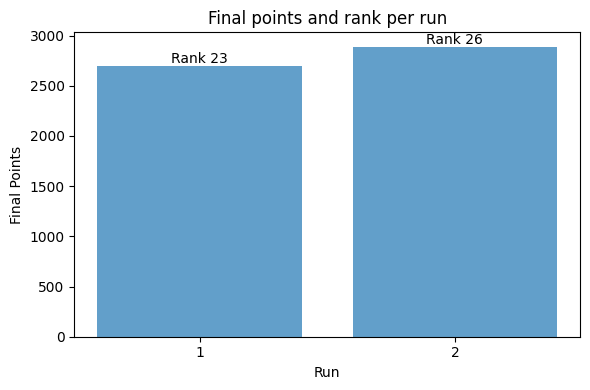

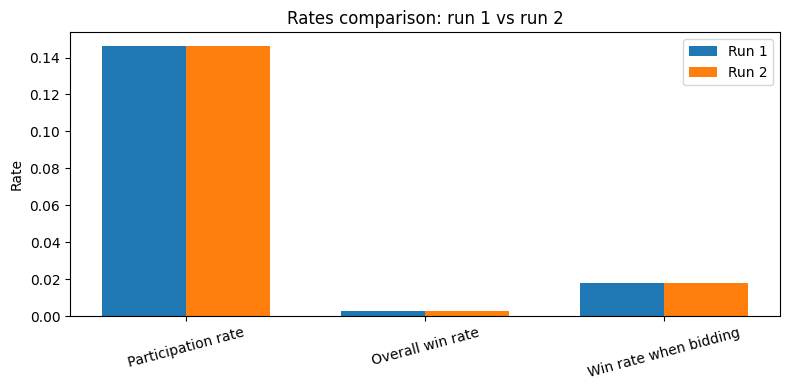

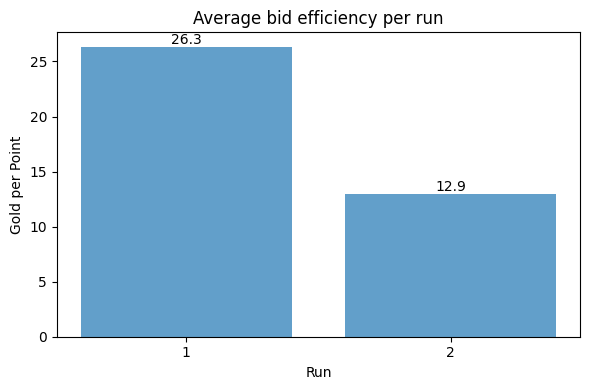

In [9]:
# plt.style.use("ggplot")  # simple modern look

# --- Raw metrics from your printouts -----------------------------------------
data = {
    "Run": [1, 2],
    "Final Rank": [my_final_state_1.get('rank'), my_final_state_2.get('rank')],
    "Final Points": [my_final_state_1.get('points'), my_final_state_2.get('points')],
    "Final Gold": [my_final_state_1.get('gold'), my_final_state_2.get('gold')],
    "Total auctions": [total_auctions_1, total_auctions_2],
    "Participations": [my_participations_1, my_participations_2],
    "Wins": [my_wins_1, my_wins_2],
    "Participation rate": [participation_rate_1, participation_rate_2],
    "Overall win rate": [win_rate_1, win_rate_2],
    "Win rate when bidding": [win_if_participated_1, win_if_participated_2],
    "Avg bid efficiency (g/p)": [efficiency_avg_1, efficiency_avg_2],
}

df_runs = pd.DataFrame(data).set_index("Run")

# --- 1) Nice comparison table -----------------------------------------------
display(df_runs.style.format({
    "Participation rate": "{:.3f}",
    "Overall win rate": "{:.3f}",
    "Win rate when bidding": "{:.3f}",
    "Avg bid efficiency (g/p)": "{:.2f}"
}).set_caption("Core metrics comparison: Run 1 vs Run 2"))

# --- 2) Plot: Final points and rank -----------------------------------------
fig, ax1 = plt.subplots(figsize=(6,4))

runs = df_runs.index.astype(str)

# bar for points
ax1.bar(runs, df_runs["Final Points"], alpha=0.7)
ax1.set_xlabel("Run")
ax1.set_ylabel("Final Points")
ax1.set_title("Final points and rank per run")

# annotate rank above bars
for x, pts, rank in zip(runs, df_runs["Final Points"], df_runs["Final Rank"]):
    ax1.text(x, pts, f"Rank {rank}", ha="center", va="bottom")

plt.tight_layout()
plt.show()

# --- 3) Plot: win/participation/efficiency ----------------------------------
fig, ax = plt.subplots(figsize=(8,4))

metrics = ["Participation rate", "Overall win rate", "Win rate when bidding"]
x = range(len(metrics))

width = 0.35
ax.bar([i - width/2 for i in x], df_runs.loc[1, metrics], width, label="Run 1")
ax.bar([i + width/2 for i in x], df_runs.loc[2, metrics], width, label="Run 2")

ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=15)
ax.set_ylabel("Rate")
ax.set_title("Rates comparison: run 1 vs run 2")
ax.legend()

plt.tight_layout()
plt.show()

# --- 4) Plot: bid efficiency -------------------------------------------------
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(runs, df_runs["Avg bid efficiency (g/p)"], alpha=0.7)
ax.set_xlabel("Run")
ax.set_ylabel("Gold per Point")
ax.set_title("Average bid efficiency per run")

for x, eff in zip(runs, df_runs["Avg bid efficiency (g/p)"]):
    ax.text(x, eff, f"{eff:.1f}", ha="center", va="bottom")

plt.tight_layout()
plt.show()

In [10]:
# ============================================================
# Pool analysis (Run 1 & Run 2)
# ============================================================

def extract_pool_timeseries(log_path: Path, my_id: str) -> pd.DataFrame:
    """
    Build a per-round pool dataframe.

    Important: In your server code, the state includes:
      - "pool": current gold_in_pool (for THIS round, after processing previous round bids)
      - "prev_pool_buys": dict of points invested in pool in the PREVIOUS round

    We'll use prev_pool_buys to measure whether we invested points,
    and pool to approximate pool value at that time.
    """
    rows = []
    with open(log_path, "r") as f:
        for line in f:
            row = json.loads(line)
            rnd = int(row.get("round", 0))

            pool_gold = int(row.get("pool", 0))
            prev_pool_buys = row.get("prev_pool_buys", {}) or {}

            my_pts = int(prev_pool_buys.get(my_id, 0))
            total_pts = 0
            for v in prev_pool_buys.values():
                try:
                    total_pts += int(v)
                except:
                    pass

            share = (my_pts / total_pts) if total_pts > 0 else 0.0

            # Approximate "gold we got back" (server uses int(pool * share), with min 1 if points>0)
            est_gold_back = int(pool_gold * share) if total_pts > 0 else 0
            if my_pts > 0:
                est_gold_back = max(1, est_gold_back)

            # Implied pool price (gold per point) for that round, based on pool/total_points
            cp_pool_sample = (pool_gold / total_pts) if total_pts > 0 else np.nan

            rows.append({
                "round": rnd,
                "pool_gold": pool_gold,
                "my_pool_points": my_pts,
                "total_pool_points": total_pts,
                "my_pool_share": share,
                "cp_pool_sample": cp_pool_sample,
                "my_pool_gold_back_est": est_gold_back,
                "gold_per_point_est": (est_gold_back / my_pts) if my_pts > 0 else np.nan,
            })

    return pd.DataFrame(rows).sort_values("round").reset_index(drop=True)

pool_df_1 = extract_pool_timeseries(LOG_FILE_ROUND_1, MY_ID)
pool_df_2 = extract_pool_timeseries(LOG_FILE_ROUND_2, MY_ID)

def pool_summary(df_pool: pd.DataFrame, label: str):
    n_bid_rounds = int((df_pool["my_pool_points"] > 0).sum())
    pts_spent = int(df_pool["my_pool_points"].sum())
    max_pts = int(df_pool["my_pool_points"].max())
    est_gold_back = int(df_pool["my_pool_gold_back_est"].sum())

    print(f"=== POOL SUMMARY {label} ===")
    print(f"Rounds with pool bids:     {n_bid_rounds}")
    print(f"Total points spent:        {pts_spent}")
    print(f"Max points in one round:   {max_pts}")
    print(f"Estimated gold returned:   {est_gold_back}")
    if pts_spent > 0:
        print(f"Estimated avg gold/point:  {est_gold_back / pts_spent:.3f}")
    print()

pool_summary(pool_df_1, "Run 1")
pool_summary(pool_df_2, "Run 2")

display(pool_df_1[pool_df_1["my_pool_points"] > 0].head(20))

=== POOL SUMMARY Run 1 ===
Rounds with pool bids:     0
Total points spent:        0
Max points in one round:   0
Estimated gold returned:   0

=== POOL SUMMARY Run 2 ===
Rounds with pool bids:     0
Total points spent:        0
Max points in one round:   0
Estimated gold returned:   0



,round,pool_gold,my_pool_points,total_pool_points,my_pool_share,cp_pool_sample,my_pool_gold_back_est,gold_per_point_est


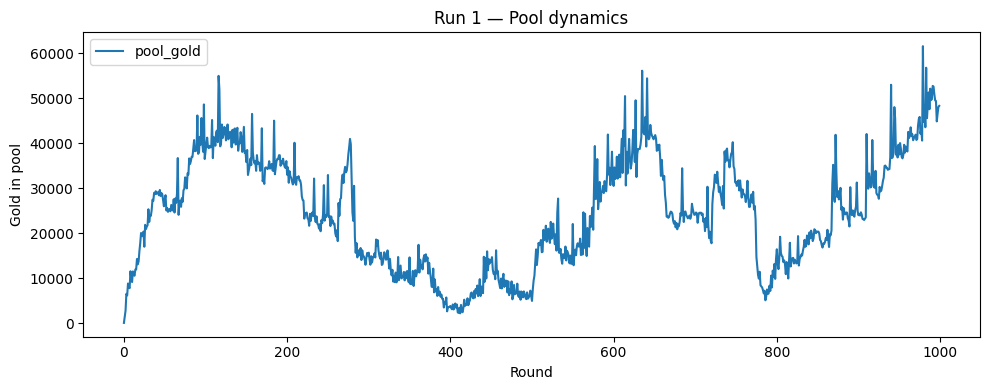

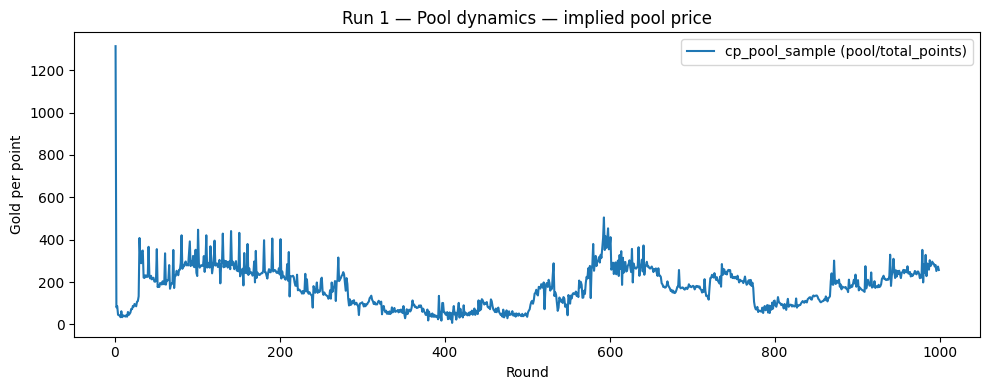

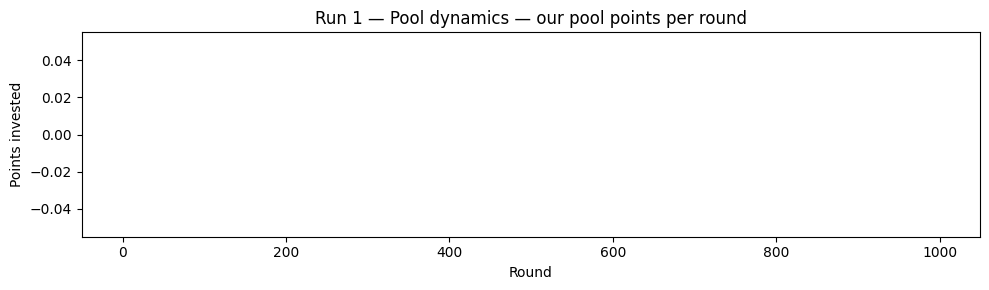

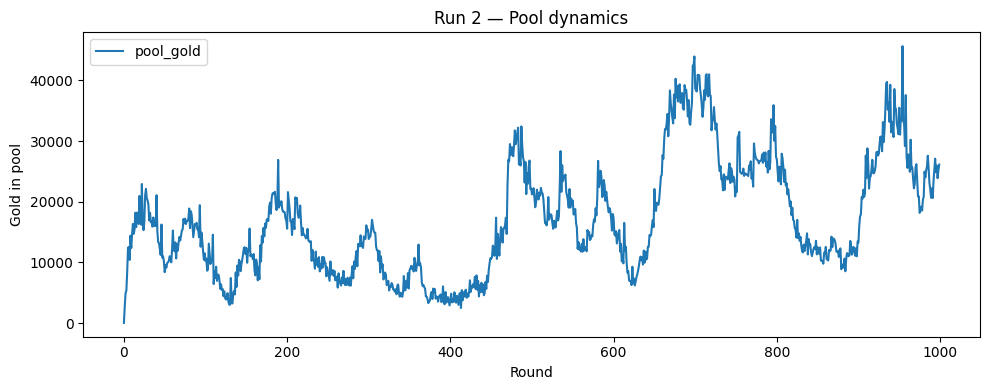

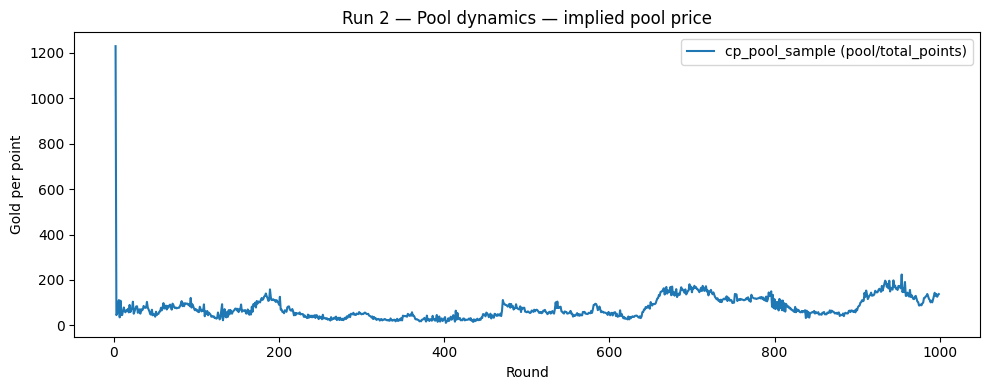

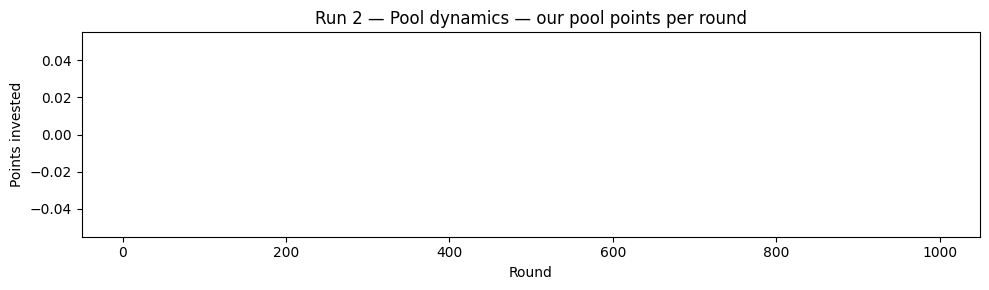

In [11]:
# ============================================================
# Pool plots (Run 1 & Run 2)
# ============================================================

def plot_pool(df_pool: pd.DataFrame, title: str):
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(df_pool["round"], df_pool["pool_gold"], label="pool_gold")
    ax.set_xlabel("Round")
    ax.set_ylabel("Gold in pool")
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(df_pool["round"], df_pool["cp_pool_sample"], label="cp_pool_sample (pool/total_points)")
    ax.set_xlabel("Round")
    ax.set_ylabel("Gold per point")
    ax.set_title(title + " — implied pool price")
    ax.legend()
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=(10,3))
    ax.bar(df_pool["round"], df_pool["my_pool_points"])
    ax.set_xlabel("Round")
    ax.set_ylabel("Points invested")
    ax.set_title(title + " — our pool points per round")
    plt.tight_layout()
    plt.show()

plot_pool(pool_df_1, "Run 1 — Pool dynamics")
plot_pool(pool_df_2, "Run 2 — Pool dynamics")


First detected collapse round (Run 1): 81
First detected collapse round (Run 2): 362


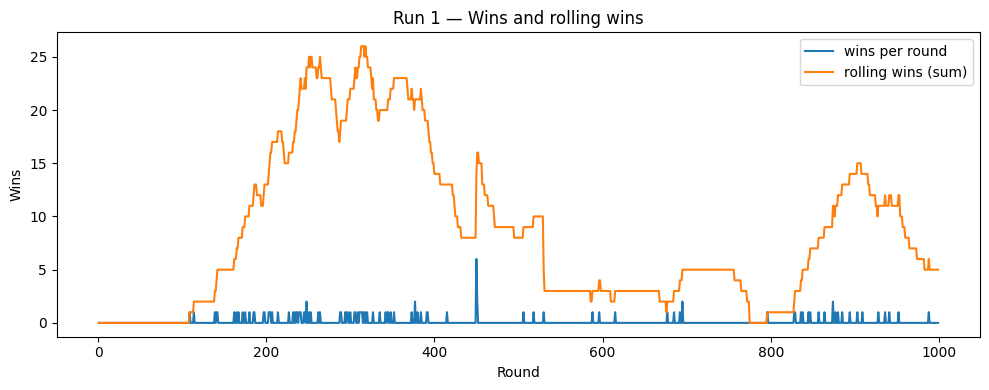

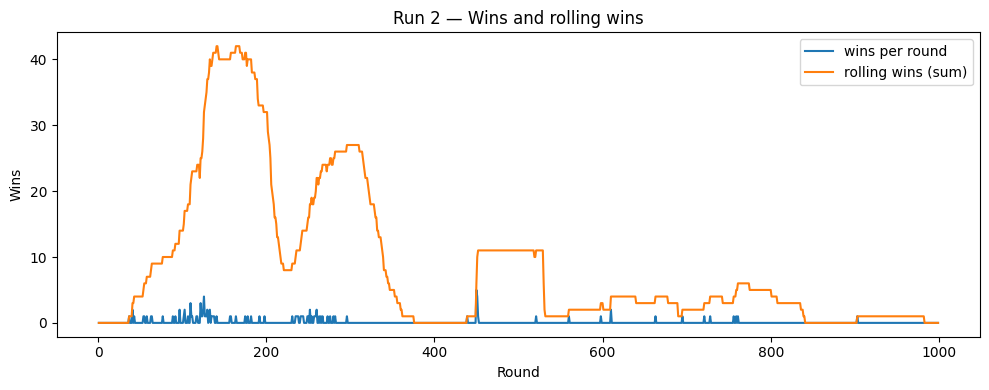

In [12]:
# ============================================================
# Win collapse / silent-phase detection
# ============================================================

def add_rolling_wins(df: pd.DataFrame, window: int = 80) -> pd.DataFrame:
    out = df.copy()
    # per auction rows -> aggregate to per round first
    per_round = out.groupby("round", as_index=False).agg(
        wins=("won","sum"),
        participated=("participated","sum"),
        auctions=("won","count"),
        points_won=("reward", lambda s: float(np.sum(s[out.loc[s.index, "won"]])))  # only rewards where won
    )
    per_round["wins_rollsum"] = per_round["wins"].rolling(window, min_periods=1).sum()
    per_round["part_rollsum"] = per_round["participated"].rolling(window, min_periods=1).sum()
    per_round["winrate_roll"] = per_round["wins_rollsum"] / per_round["part_rollsum"].replace(0, np.nan)
    return per_round

per_round_1 = add_rolling_wins(df_1, window=80)
per_round_2 = add_rolling_wins(df_2, window=80)

def find_collapse_round(per_round: pd.DataFrame, window: int = 80, threshold_wins: int = 1):
    # "collapse" = after window, rolling wins becomes almost zero
    for r, w in zip(per_round["round"], per_round["wins_rollsum"]):
        if r > window and w <= threshold_wins:
            return int(r)
    return None

collapse_1 = find_collapse_round(per_round_1, window=80, threshold_wins=1)
collapse_2 = find_collapse_round(per_round_2, window=80, threshold_wins=1)

print("First detected collapse round (Run 1):", collapse_1)
print("First detected collapse round (Run 2):", collapse_2)

# Plots
def plot_wins(per_round: pd.DataFrame, title: str):
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(per_round["round"], per_round["wins"], label="wins per round")
    ax.plot(per_round["round"], per_round["wins_rollsum"], label="rolling wins (sum)")
    ax.set_xlabel("Round")
    ax.set_ylabel("Wins")
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_wins(per_round_1, "Run 1 — Wins and rolling wins")
plot_wins(per_round_2, "Run 2 — Wins and rolling wins")


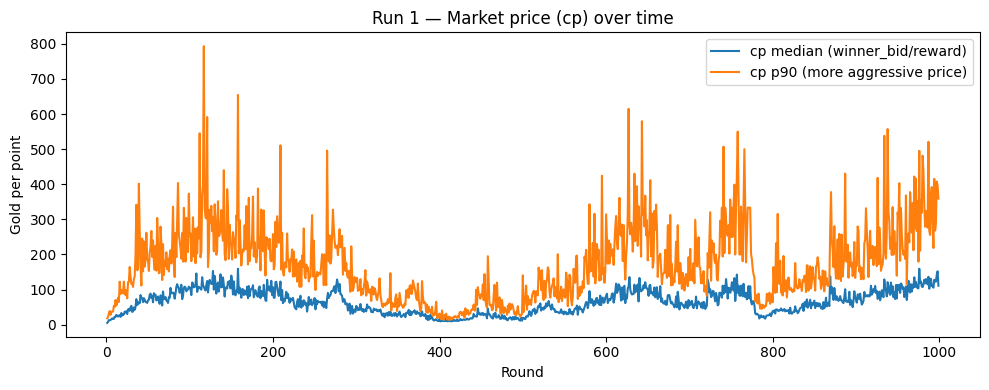

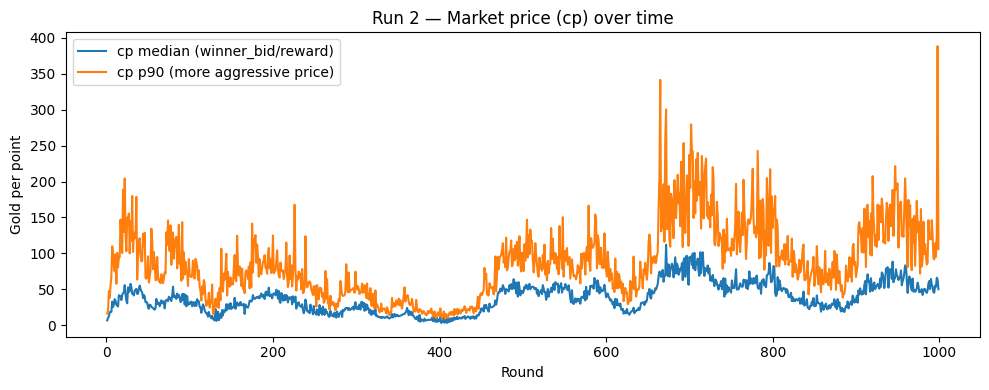

In [13]:
# ============================================================
# cp (auction market price) estimation from logs
# ============================================================

def extract_cp_timeseries(log_path: Path) -> pd.DataFrame:
    rows = []
    with open(log_path, "r") as f:
        for line in f:
            row = json.loads(line)
            rnd = int(row.get("round", 0))
            prev = row.get("prev_auctions", {}) or {}

            samples = []
            for auc in prev.values():
                reward = int(auc.get("reward", 0))
                bids = auc.get("bids", []) or []
                if reward > 0 and bids:
                    win_bid = int(bids[0]["gold"])
                    samples.append(win_bid / reward)

            cp_median = float(np.median(samples)) if samples else np.nan
            cp_p90 = float(np.percentile(samples, 90)) if len(samples) >= 5 else np.nan

            rows.append({"round": rnd, "cp_median": cp_median, "cp_p90": cp_p90})

    return pd.DataFrame(rows).sort_values("round").reset_index(drop=True)

cp_df_1 = extract_cp_timeseries(LOG_FILE_ROUND_1)
cp_df_2 = extract_cp_timeseries(LOG_FILE_ROUND_2)

def plot_cp(cp_df: pd.DataFrame, title: str):
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(cp_df["round"], cp_df["cp_median"], label="cp median (winner_bid/reward)")
    ax.plot(cp_df["round"], cp_df["cp_p90"], label="cp p90 (more aggressive price)")
    ax.set_xlabel("Round")
    ax.set_ylabel("Gold per point")
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_cp(cp_df_1, "Run 1 — Market price (cp) over time")
plot_cp(cp_df_2, "Run 2 — Market price (cp) over time")


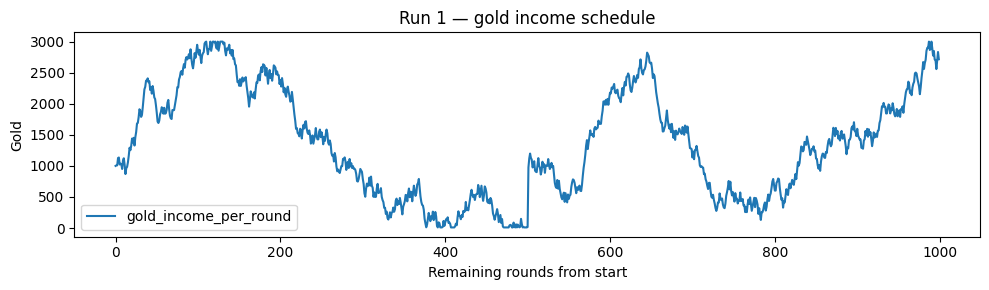

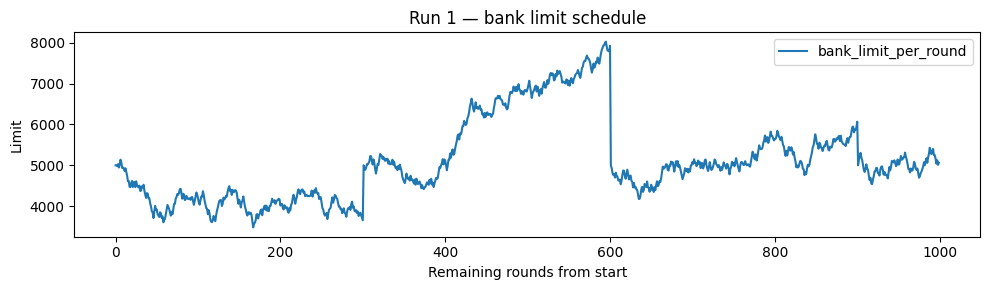

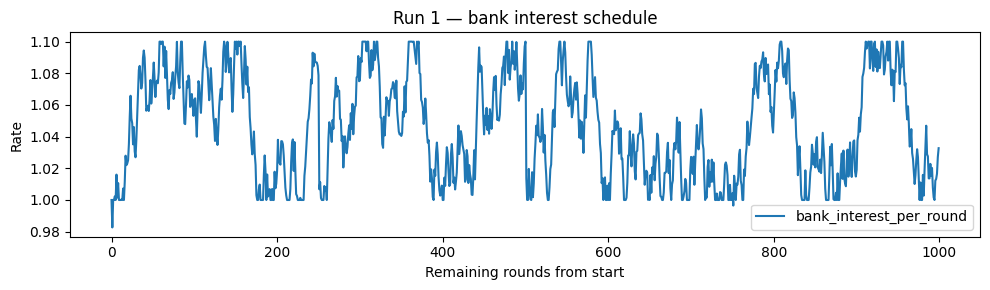

Implied total rounds: 1000


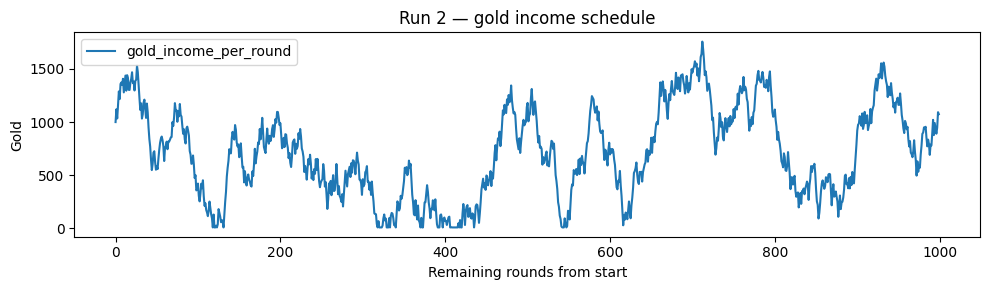

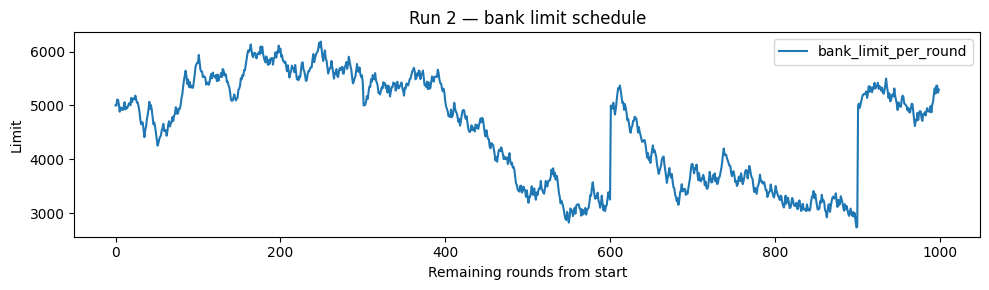

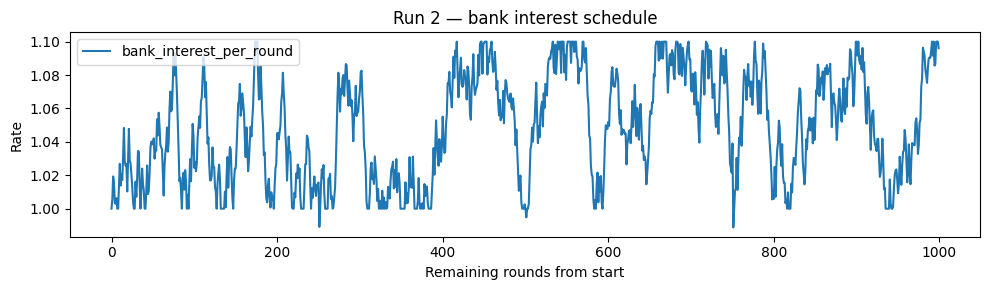

Implied total rounds: 1000


In [14]:
# ============================================================
# Server schedules (remainder_*) — shows game changes & volatility
# ============================================================

def plot_remainders(log_path: Path, title_prefix: str):
    with open(log_path, "r") as f:
        first = json.loads(next(f))

    inc = first.get("remainder_gold_income", None)
    lim = first.get("remainder_bank_limit", None)
    intr = first.get("remainder_bank_interest", None)

    if inc is None or lim is None or intr is None:
        print("No remainder_* arrays found in:", log_path)
        return

    x = np.arange(len(inc))

    fig, ax = plt.subplots(figsize=(10,3))
    ax.plot(x, inc, label="gold_income_per_round")
    ax.set_title(f"{title_prefix} — gold income schedule")
    ax.set_xlabel("Remaining rounds from start")
    ax.set_ylabel("Gold")
    ax.legend()
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=(10,3))
    ax.plot(x, lim, label="bank_limit_per_round")
    ax.set_title(f"{title_prefix} — bank limit schedule")
    ax.set_xlabel("Remaining rounds from start")
    ax.set_ylabel("Limit")
    ax.legend()
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=(10,3))
    ax.plot(x, intr, label="bank_interest_per_round")
    ax.set_title(f"{title_prefix} — bank interest schedule")
    ax.set_xlabel("Remaining rounds from start")
    ax.set_ylabel("Rate")
    ax.legend()
    plt.tight_layout()
    plt.show()

    print("Implied total rounds:", len(inc))

plot_remainders(LOG_FILE_ROUND_1, "Run 1")
plot_remainders(LOG_FILE_ROUND_2, "Run 2")


In [15]:
def build_round_df(log_path: Path, my_id: str) -> pd.DataFrame:
    """
    Creates a per-round dataframe with:
    - my gold/points
    - pool size + whether we bought pool in previous round (prev_pool_buys)
    - cp estimate proxy from prev_auctions (median winner_bid / reward)
    - win counts per round (from prev_auctions, i.e. auctions resolved in that round)
    """
    rows = []

    with open(log_path, "r") as f:
        for line in f:
            row = json.loads(line)
            rnd = row.get("round")
            if rnd is None:
                continue

            states = row.get("states", {})
            me = states.get(my_id, {"gold": 0, "points": 0})
            my_gold = int(me.get("gold", 0))
            my_points = int(me.get("points", 0))

            pool_gold = int(row.get("pool", 0))
            prev_pool_buys = row.get("prev_pool_buys", {}) or {}
            my_pool_points = int(prev_pool_buys.get(my_id, 0)) if my_id in prev_pool_buys else 0
            total_pool_points = int(sum(int(v) for v in prev_pool_buys.values())) if prev_pool_buys else 0

            # Lead vs best opponent (for your pool gating logic)
            other_points = [int(st.get("points", 0)) for aid, st in states.items() if aid != my_id]
            best_other = max(other_points) if other_points else 0
            lead = my_points - best_other

            # cp proxy from prev_auctions: median(winner_bid/reward) over positive reward auctions
            prev_auctions = row.get("prev_auctions", {}) or {}
            cp_samples = []
            wins_this_round = 0
            participations_this_round = 0

            for auc_id, auc in prev_auctions.items():
                reward = int(auc.get("reward", 0))
                bids = auc.get("bids", []) or []
                if reward > 0 and bids:
                    winner_bid = int(bids[0]["gold"])
                    cp_samples.append(winner_bid / reward)

                # did we participate / win? (note: prev_auctions are "resolved this round")
                my_bid = None
                for b in bids:
                    if b.get("a_id") == my_id:
                        my_bid = int(b.get("gold", 0))
                        break
                if my_bid is not None:
                    participations_this_round += 1
                    if len(bids) > 0 and bids[0].get("a_id") == my_id:
                        wins_this_round += 1

            cp_median = float(np.median(cp_samples)) if len(cp_samples) else np.nan

            # server hints (new game): remaining arrays exist
            rem_income = row.get("remainder_gold_income", None)
            rem_len = len(rem_income) if isinstance(rem_income, list) else None

            rows.append({
                "round": int(rnd),
                "my_gold": my_gold,
                "my_points": my_points,
                "best_other_points": best_other,
                "lead_points": lead,
                "pool_gold": pool_gold,
                "my_pool_points": my_pool_points,
                "total_pool_points": total_pool_points,
                "cp_median_proxy": cp_median,
                "wins_resolved": wins_this_round,
                "participations_resolved": participations_this_round,
                "remainder_len_hint": rem_len,
            })

    df = pd.DataFrame(rows).sort_values("round").reset_index(drop=True)
    return df


In [16]:
df_round1 = build_round_df(LOG_FILE_ROUND_1, MY_ID)
df_round2 = build_round_df(LOG_FILE_ROUND_2, MY_ID)

print("Run1: pool points ever > 0 ?", (df_round1["my_pool_points"] > 0).any())
print("Run2: pool points ever > 0 ?", (df_round2["my_pool_points"] > 0).any())

display(df_round1[["round","my_pool_points","pool_gold","total_pool_points","lead_points"]].head(10))

Run1: pool points ever > 0 ? False
Run2: pool points ever > 0 ? False


,round,my_pool_points,pool_gold,total_pool_points,lead_points
0,0,0,27,0,0
1,1,0,1314,1,-105
2,2,0,2735,34,-143
3,3,0,6484,75,-194
4,4,0,6133,135,-206
5,5,0,8782,202,-245
6,6,0,8009,195,-314
7,7,0,7750,229,-306
8,8,0,11503,186,-481
9,9,0,9895,292,-425


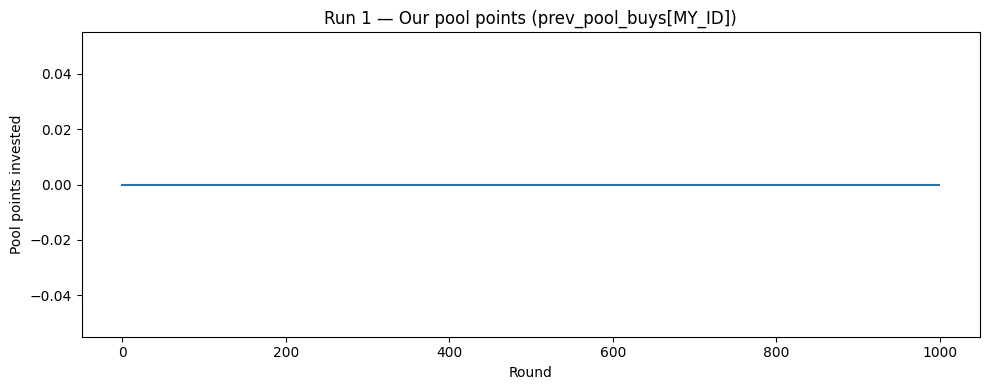

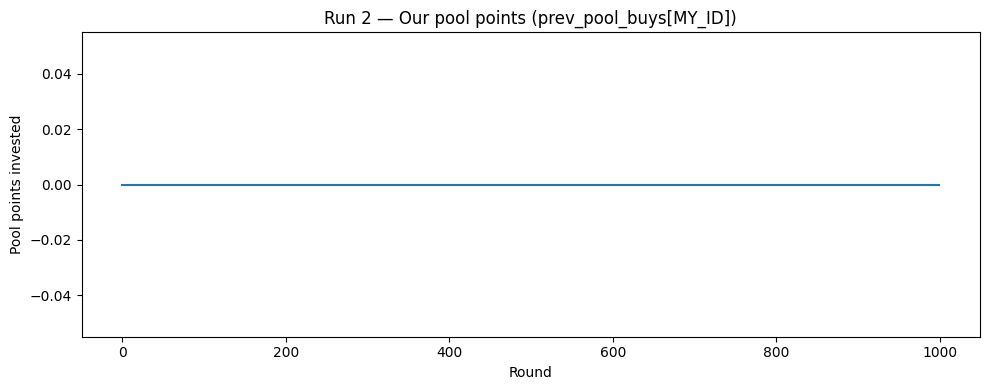

In [17]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(df_round1["round"], df_round1["my_pool_points"])
ax.set_title("Run 1 — Our pool points (prev_pool_buys[MY_ID])")
ax.set_xlabel("Round")
ax.set_ylabel("Pool points invested")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(df_round2["round"], df_round2["my_pool_points"])
ax.set_title("Run 2 — Our pool points (prev_pool_buys[MY_ID])")
ax.set_xlabel("Round")
ax.set_ylabel("Pool points invested")
plt.tight_layout()
plt.show()

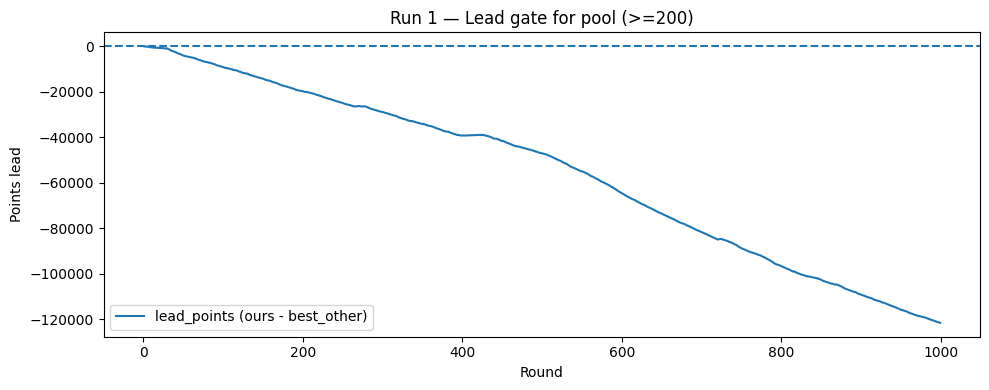

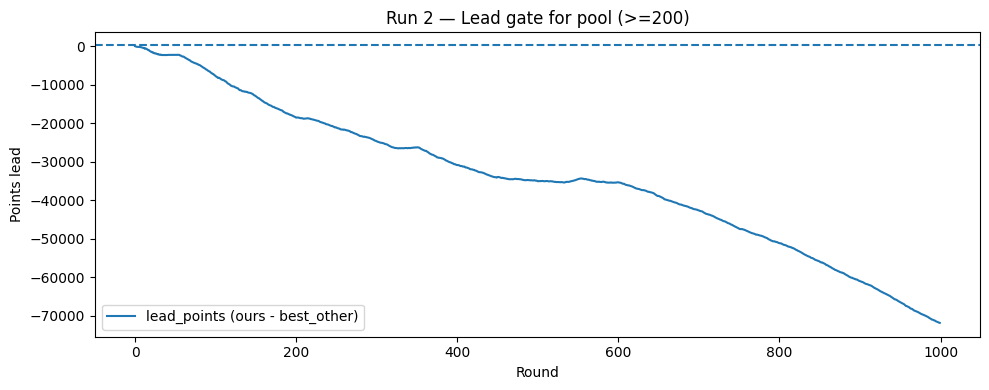

In [18]:
def plot_pool_gates(df: pd.DataFrame, title: str):
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(df["round"], df["lead_points"], label="lead_points (ours - best_other)")
    ax.axhline(200, linestyle="--")  # LEAD_POINTS_MIN from your agent
    ax.set_title(title + " — Lead gate for pool (>=200)")
    ax.set_xlabel("Round")
    ax.set_ylabel("Points lead")
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_pool_gates(df_round1, "Run 1")
plot_pool_gates(df_round2, "Run 2")

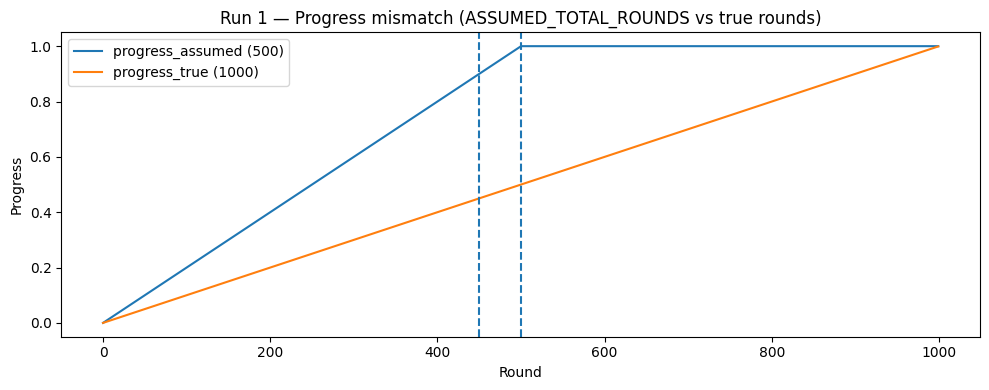

In [19]:
ASSUMED = 500
TRUE = 1000

def add_progress_cols(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    d["progress_assumed"] = np.clip(d["round"] / ASSUMED, 0, 1)
    d["progress_true"] = np.clip(d["round"] / TRUE, 0, 1)
    d["endgame_assumed"] = d["progress_assumed"] >= 0.9
    d["endgame_true"] = d["progress_true"] >= 0.9
    return d

df_round1p = add_progress_cols(df_round1)
df_round2p = add_progress_cols(df_round2)

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(df_round1p["round"], df_round1p["progress_assumed"], label="progress_assumed (500)")
ax.plot(df_round1p["round"], df_round1p["progress_true"], label="progress_true (1000)")
ax.axvline(450, linestyle="--")
ax.axvline(500, linestyle="--")
ax.set_title("Run 1 — Progress mismatch (ASSUMED_TOTAL_ROUNDS vs true rounds)")
ax.set_xlabel("Round")
ax.set_ylabel("Progress")
ax.legend()
plt.tight_layout()
plt.show()

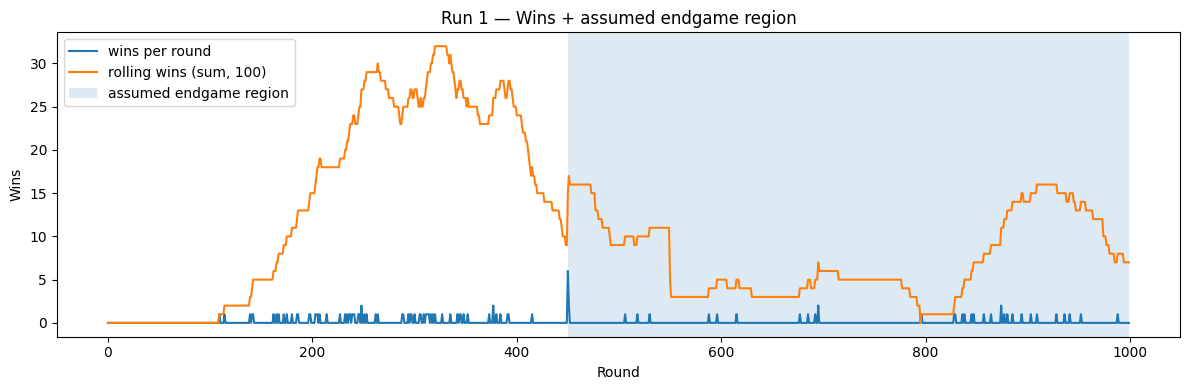

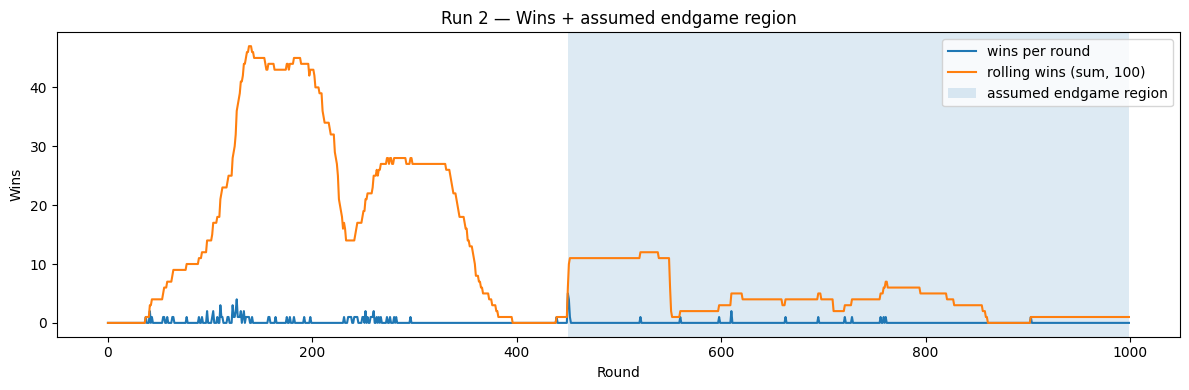

In [20]:
def plot_wins_with_endgame(df_roundp: pd.DataFrame, title: str, window: int = 100):
    d = df_roundp.copy()
    d["rolling_wins"] = d["wins_resolved"].rolling(window, min_periods=1).sum()

    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(d["round"], d["wins_resolved"], label="wins per round")
    ax.plot(d["round"], d["rolling_wins"], label=f"rolling wins (sum, {window})")

    # shade assumed endgame region
    eg = d["endgame_assumed"].values
    if eg.any():
        first_eg = d.loc[d["endgame_assumed"], "round"].iloc[0]
        ax.axvspan(first_eg, d["round"].max(), alpha=0.15, label="assumed endgame region")

    ax.set_title(title)
    ax.set_xlabel("Round")
    ax.set_ylabel("Wins")
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_wins_with_endgame(df_round1p, "Run 1 — Wins + assumed endgame region")
plot_wins_with_endgame(df_round2p, "Run 2 — Wins + assumed endgame region")

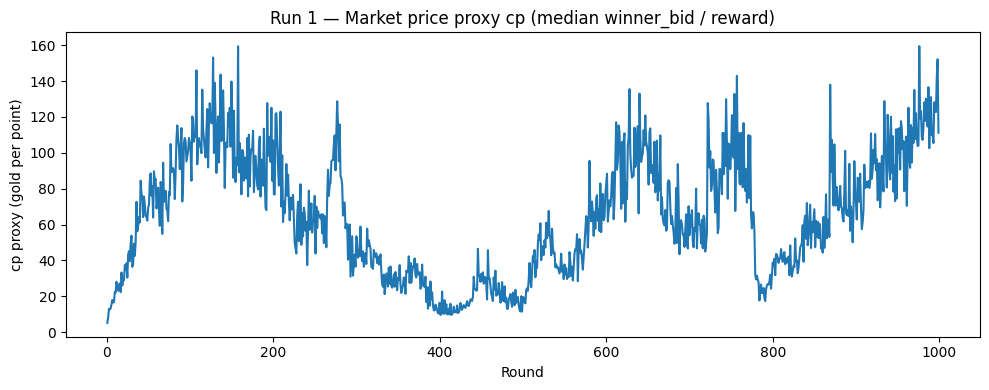

In [21]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(df_round1p["round"], df_round1p["cp_median_proxy"])
ax.set_title("Run 1 — Market price proxy cp (median winner_bid / reward)")
ax.set_xlabel("Round")
ax.set_ylabel("cp proxy (gold per point)")
plt.tight_layout()
plt.show()

In [22]:
def extract_gold_timeseries(log_path):
    """
    Extract per-round gold for all agents.
    Returns:
        rounds: list[int]
        gold_df: DataFrame with columns = agent_id, rows = rounds
    """
    records = []

    with open(log_path, "r") as f:
        for line in f:
            row = json.loads(line)
            rnd = row.get("round")
            states = row.get("states", {})
            if rnd is None:
                continue

            for aid, st in states.items():
                records.append({
                    "round": rnd,
                    "agent_id": aid,
                    "gold": st.get("gold", 0)
                })

    df = pd.DataFrame(records)
    gold_df = df.pivot(index="round", columns="agent_id", values="gold")
    return gold_df

In [23]:
gold_ts_1 = extract_gold_timeseries(LOG_FILE_ROUND_1)

my_gold = gold_ts_1[MY_ID]
median_gold = gold_ts_1.median(axis=1)

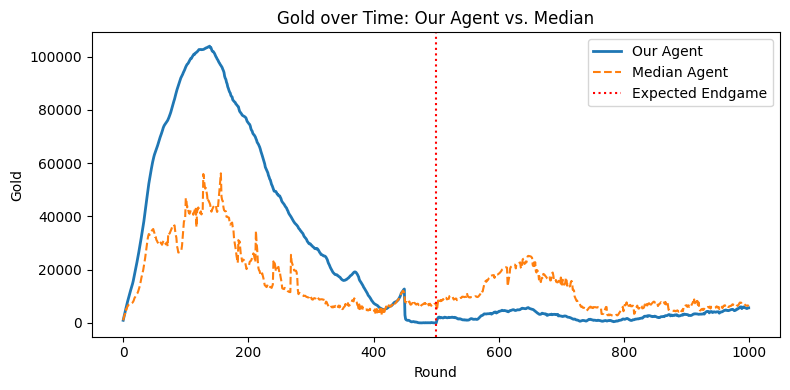

In [24]:
plt.figure(figsize=(8,4))

plt.plot(my_gold.index, my_gold.values, label="Our Agent", linewidth=2)
plt.plot(median_gold.index, median_gold.values, label="Median Agent", linestyle="--")

plt.axvline(500, color="red", linestyle=":", label="Expected Endgame")

plt.xlabel("Round")
plt.ylabel("Gold")
plt.title("Gold over Time: Our Agent vs. Median")
plt.legend()
plt.tight_layout()
plt.show()